# **GAN**

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


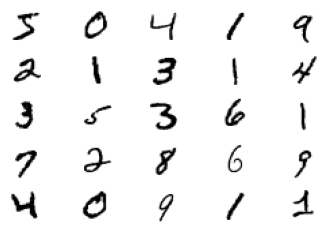

In [3]:
from matplotlib import pyplot as plt

for i in range(25):
  # define subplot
  plt.subplot(5, 5, 1 + i)
  # turn off axis
  plt.subplot(5, 5, 1 + i)
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(trainX[i], cmap='gray_r')   #gray to reverse colors
plt.show()


# Discriminator
The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.

In [4]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):

  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
 
  return model

In [5]:
discriminator = define_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

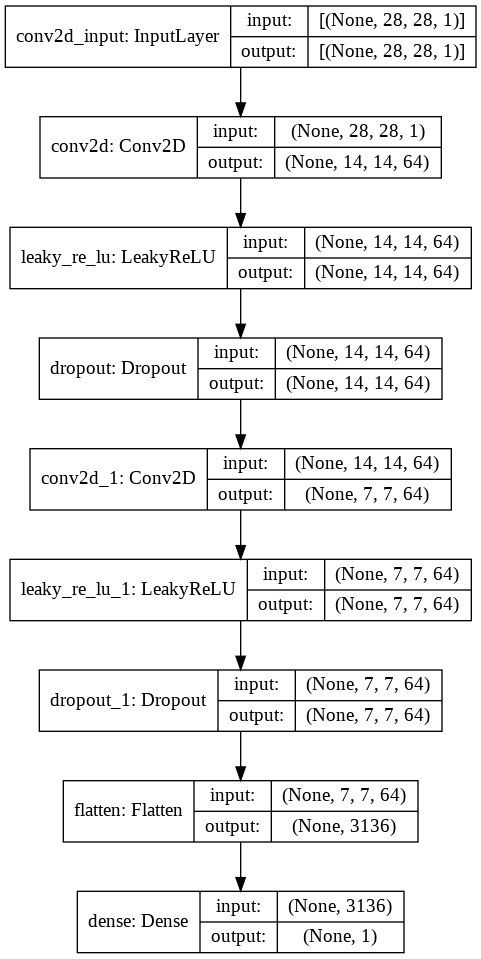

In [6]:
from keras.utils.vis_utils import plot_model

plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint

 
# load and prepare mnist training images
def load_real_samples():
	
  # load mnist digits dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X
 
# load image data, 60k training and 10k testing
dataset = load_real_samples()

In [8]:
# generate n real samples from dataset with class labels (1)
def generate_real_samples(dataset, n_samples):

	# list of 'n_samples' random indexes in [0,60k]
	ix = randint(0, dataset.shape[0], n_samples)
	# list of selected images from indexes
	X = dataset[ix]
	# vector of 'real' class labels (1)
	y = ones((n_samples, 1))
  # return selected images and vector of ones, of same length
	return X, y
 

# generate n fake samples (completely random) with class labels (0)
def generate_fake_samples(n_samples):

	# generate 28*28*n_samples uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)           # (flatten vector)
	# reshape them into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))   # nsamples vectors of (28*28*1)
	# vector of 'real' class labels (0)
	y = zeros((n_samples, 1))               
  # return selected images and vector of zeros, of same length
	return X, y

 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):

  half_batch = int(n_batch / 2)

  # manually enumerate epochs
  for i in range(n_iter):

    # get randomly selected 'real' samples from dataset
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = discriminator.train_on_batch(X_real, y_real)

    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = discriminator.train_on_batch(X_fake, y_fake)

    # summarize performances
    print('-%d:  real=%.0f%%  fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

-1:  real=63%  fake=29%
-2:  real=66%  fake=41%
-3:  real=70%  fake=59%
-4:  real=68%  fake=78%
-5:  real=69%  fake=88%
-6:  real=73%  fake=96%
-7:  real=65%  fake=99%
-8:  real=66%  fake=100%
-9:  real=66%  fake=99%
-10:  real=66%  fake=100%
-11:  real=59%  fake=100%
-12:  real=68%  fake=100%
-13:  real=72%  fake=100%
-14:  real=55%  fake=100%
-15:  real=59%  fake=100%
-16:  real=60%  fake=100%
-17:  real=59%  fake=100%
-18:  real=73%  fake=100%
-19:  real=78%  fake=100%
-20:  real=70%  fake=100%
-21:  real=77%  fake=100%
-22:  real=79%  fake=100%
-23:  real=87%  fake=100%
-24:  real=84%  fake=100%
-25:  real=91%  fake=100%
-26:  real=94%  fake=100%
-27:  real=91%  fake=100%
-28:  real=95%  fake=100%
-29:  real=98%  fake=100%
-30:  real=98%  fake=100%
-31:  real=99%  fake=100%
-32:  real=97%  fake=100%
-33:  real=99%  fake=100%
-34:  real=99%  fake=100%
-35:  real=99%  fake=100%
-36:  real=100%  fake=100%
-37:  real=100%  fake=100%
-38:  real=100%  fake=100%
-39:  real=100%  fake=100%

In [ ]:
# fit the discriminator
train_discriminator(discriminator, dataset)

# Generator

In [9]:
from keras.layers import Conv2DTranspose, Reshape

# define the standalone generator model
def define_generator(latent_dim):
  
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  
	return model

In [10]:
latent_dim=100
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

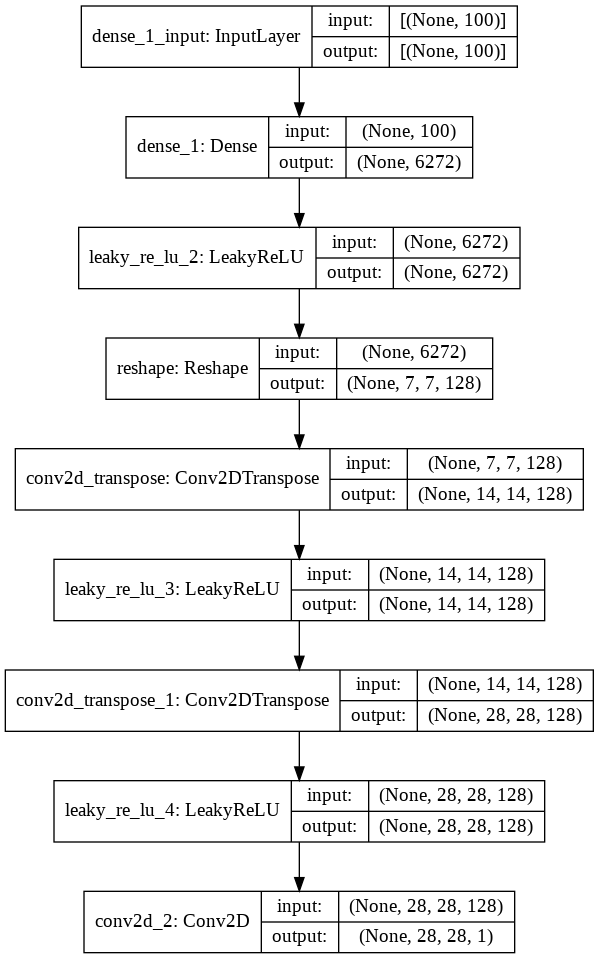

In [11]:
# plot the model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
from numpy.random import randn

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	
  # arrays of random numbers from gaussian
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

  
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):

	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

## Generate random gaussian samples (pixels in [0,1])


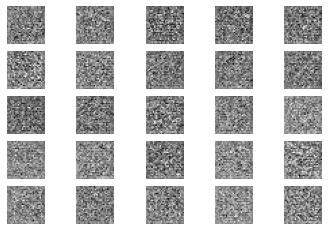

In [13]:
n_samples = 25
X, _ = generate_fake_samples(generator, latent_dim, n_samples)

# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()


# GAN
* **Generator**: concerned with the discriminator’s performance on fake examples. 
  * *input*: random points in latent space
  * *output*: samples
* **Discriminator**: only concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner. We will set discriminator part of the gan.trainable=False.
  * *input*: generator output samples+
  * *output*: real(1) or fake(0)

BackPropagation to update generator weights.

NB: We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1). The discriminator will then classify the generated samples as not real (0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model's generator weights to correct for this error, thus making the generator better at generating good fake samples.

In [14]:
# define the GAN: combined generator and discriminator model, for updating the generator
def build_gan(generator, discriminator):

	# make weights in the discriminator not trainable
	discriminator.trainable = False
  
	# connect them
	model = Sequential()
	model.add(generator)
	model.add(discriminator)

	return model

In [15]:
gan = build_gan(generator,discriminator)

gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


### GAN model expects images as input and predicts a single value as output.

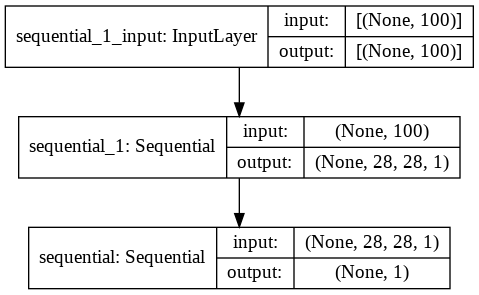

In [16]:
# plot gan model
plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

# Training
The weights in the generator model are updated based on the performance of the discriminator model. If the discriminator is good at detecting fakes, the generator is updated more, and viceversa. (adversarial relationship or zero-sum). NB:

* we first update the discriminator model with real and fake samples, then update the generator via the composite model

* number of batches within an epoch: how many times the batch size divides into the training dataset. We have a dataset of 60K samples, so there are 234 batches per epoch.

* The discriminator model is updated once per batch by combining one half a batch of fake and real examples into a single batch via the vstack()



In [17]:
from numpy import vstack

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):

  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  # manually enumerate epochs
  for i in range(n_epochs):
    
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('Epoch %d,  %d/%d,    discriminator_loss=%.3f  -  generator_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    
    # evaluate the model performance, sometimes
    if (i+1) % 233 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [18]:
train(generator, discriminator, gan, dataset, latent_dim)

Output streaming troncato alle ultime 5000 righe.
>11, 178/234, discriminator_loss=0.000, generator_loss=9.383
>11, 179/234, discriminator_loss=0.000, generator_loss=9.441
>11, 180/234, discriminator_loss=0.000, generator_loss=9.506
>11, 181/234, discriminator_loss=0.000, generator_loss=9.503
>11, 182/234, discriminator_loss=0.000, generator_loss=9.523
>11, 183/234, discriminator_loss=0.000, generator_loss=9.419
>11, 184/234, discriminator_loss=0.000, generator_loss=9.459
>11, 185/234, discriminator_loss=0.000, generator_loss=9.474
>11, 186/234, discriminator_loss=0.001, generator_loss=9.369
>11, 187/234, discriminator_loss=0.000, generator_loss=9.509
>11, 188/234, discriminator_loss=0.000, generator_loss=9.504
>11, 189/234, discriminator_loss=0.000, generator_loss=9.369
>11, 190/234, discriminator_loss=0.000, generator_loss=9.496
>11, 191/234, discriminator_loss=0.000, generator_loss=9.323
>11, 192/234, discriminator_loss=0.000, generator_loss=9.470
>11, 193/234, discriminator_loss=0.

KeyboardInterrupt: ignored

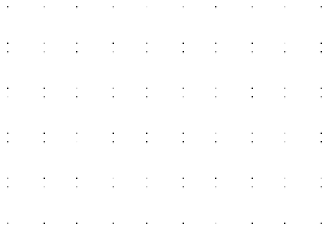

In [73]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):

	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):

  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    #print(examples[i,:,:,0])
    plt.imshow(examples[i,:,:,0], cmap='gray_r')
  plt.show()

# load model
#model = load_model('generator_model_100.h5')

# generate images
latent_points = generate_latent_points(100, 25)

# generate images
X = generator.predict(latent_points)

# plot the result
#print(X.shape)

save_plot(X, 5)